In [ ]:
#векторизации нет , логистическая регрессия, сбаланстроват, использовать все методы мо

Загрузка необходимых библиотек

In [34]:
# для парссинга
import requests
from bs4 import BeautifulSoup
# работа с данными
import pandas as pd
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
# очистка текста
import re
# обработка текстов и балансировка классов
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# оценка моделей
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE

In [35]:
# Загрузка стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
stop_words

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

# Парссинг данных

In [28]:
# Список для хранения всех отзывов
all_reviews = []

In [29]:
# https://www.restoran.ru/msk/opinions/?PAGEN_1=2
# Проверяем успешность запроса-Q  Q
def parse(url):
  response = requests.get(url)
  global all_reviews
  if response.status_code == 200:
      # Парсим содержимое страницы с помощью BeautifulSoup
      soup = BeautifulSoup(response.content, 'html.parser')

      # Находим все элементы с отзывами
      reviews = soup.find_all('div', class_='review-wrap')

      # Извлекаем текст отзывов
      for review in reviews:
          review_list = [
              review.find('div', class_="place-name-wrap").get_text(strip=True) if review.find('div', class_="place-name-wrap") else None,               #Наименование ресторана
              review.find('span', class_='review-text-preview').get_text(strip=True) if review.find('span', class_='review-text-preview') else None,          #Комментарий
              review.find('div', class_='review-rating has-grade-values').get_text(strip=True) if review.find('div', class_='review-rating has-grade-values') else None #Оценка
              ]
          review_text = review.find('span', class_='review-text-preview').get_text(strip=True)
          all_reviews.append(review_list)
  else:
      print(f"Ошибка при запросе: {response.status_code}")

In [30]:
# Функция для перехода по страницам и извлечения данных
def parse_all_pages(base_url, num_pages):
    for page in range(1, num_pages + 1):
      url = f"{base_url}{page}"
      print(f"Парсинг страницы {page}: {url}")
      parse(url)


In [32]:
parse_all_pages('https://www.restoran.ru/msk/opinions/?PAGEN_1=', 2000)
all_reviews

Парсинг страницы 1: https://www.restoran.ru/msk/opinions/?PAGEN_1=1
Парсинг страницы 2: https://www.restoran.ru/msk/opinions/?PAGEN_1=2
Парсинг страницы 3: https://www.restoran.ru/msk/opinions/?PAGEN_1=3
Парсинг страницы 4: https://www.restoran.ru/msk/opinions/?PAGEN_1=4
Парсинг страницы 5: https://www.restoran.ru/msk/opinions/?PAGEN_1=5
Парсинг страницы 6: https://www.restoran.ru/msk/opinions/?PAGEN_1=6
Парсинг страницы 7: https://www.restoran.ru/msk/opinions/?PAGEN_1=7
Парсинг страницы 8: https://www.restoran.ru/msk/opinions/?PAGEN_1=8
Парсинг страницы 9: https://www.restoran.ru/msk/opinions/?PAGEN_1=9
Парсинг страницы 10: https://www.restoran.ru/msk/opinions/?PAGEN_1=10
Парсинг страницы 11: https://www.restoran.ru/msk/opinions/?PAGEN_1=11
Парсинг страницы 12: https://www.restoran.ru/msk/opinions/?PAGEN_1=12
Парсинг страницы 13: https://www.restoran.ru/msk/opinions/?PAGEN_1=13
Парсинг страницы 14: https://www.restoran.ru/msk/opinions/?PAGEN_1=14
Парсинг страницы 15: https://www.resto

[['Ресторан Modus / Модус4.8',
  'Модус обожаю за его авторское представление блюд - всегда вкусно, красиво, вроде на первый взгляд заказываешь привычное блюдо, но по факту видишь что-то особенное необычное, по своему индивидуальное и...',
  '5.0'],
 ['Ресторан BAMBOO.BAR4.8',
  'Нам понравился этот ресторан. Были здесь на презентации компании. Все необходимое нам предоставили. Были хорошие проекторы, микрофоны. Спасибо также персоналу за быстрое и вежливое обслуживание. Хорош...',
  '5.0'],
 ['Клуб Hot Collection / Хот Коллекшн5',
  'Этот стриптиз-клуб в центре Москвы порадовал меня на все 100! Отличный персонал, вкусный кальян, красивая атмосфера и приятные цены на приваты. Акции и скидки делают поход сюда еще более приятным. В о...',
  '5.0'],
 ['Центральный Гранд-кафе Dr. Живаго4.8',
  'Постоянно посещаем данное заведение с подругами, любим отдохнуть здесь. Работают приятные сотрудники в зале и замечательный бармен. Кухня на высшем уровне. Ресторан удачно расположен, вид на Кремль'

In [33]:
len(all_reviews)

44000

In [37]:
df = pd.DataFrame(all_reviews, columns=['cafe', 'review', 'rating'])
df.head()

,cafe,review,rating
0,Ресторан Modus / Модус4.8,Модус обожаю за его авторское представление бл...,5.0
1,Ресторан BAMBOO.BAR4.8,Нам понравился этот ресторан. Были здесь на пр...,5.0
2,Клуб Hot Collection / Хот Коллекшн5,Этот стриптиз-клуб в центре Москвы порадовал м...,5.0
3,Центральный Гранд-кафе Dr. Живаго4.8,Постоянно посещаем данное заведение с подругам...,5.0
4,Ресторан #СибирьСибирь2.1,В этот раз хочу написать не про кухню ресторан...,1.0


# Предобработка данных


In [41]:
# Удаление строк с пустыми значениями
df.dropna(inplace=True)
# Предобработка данных
df['rating'] = df['rating'].astype(float).astype(int)

# Функция для предобработки текста
def preprocess_text(text):
    # Токенизация
    tokens = word_tokenize(text.lower())

    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Стемминг
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Применение предобработки к тексту
df['review'] = df['review'].apply(preprocess_text)



In [42]:
# Описательная статистика
print(df.describe())

            rating
count  8468.000000
mean      4.006613
std       1.368530
min       1.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       5.000000


In [43]:
# Количество отзывов для каждого кафе
rating_counts = df['rating'].value_counts()
print(rating_counts)

rating
5    4490
4    2040
1     971
2     554
3     413
Name: count, dtype: int64


In [44]:
# Средние рейтинги для каждого кафе
cafe_ratings = df.groupby('cafe')['rating'].mean()
print(cafe_ratings)

cafe
CITY FOOD Европолис4.9                      4.500000
Банкетный зал Art Moscow5                   4.923077
Банкетный зал Artiland / Артиленд5          5.000000
Банкетный зал Chalet / Шале5                4.777778
Банкетный зал Elleon / Эллеон4.6            5.000000
                                              ...   
Чайхана Урюк (Люберцы) (закрыт)3            3.000000
Чайхана Урюк (Павелецкая) закрыт2.7         3.250000
Чайхана Урюк (Профсоюзная) закрыт5          5.000000
Чайхана Урюк (ТРЦ Метрополис)1              1.000000
Чайхана Урюк (пр. Вернадского) закрыт2.9    2.333333
Name: rating, Length: 928, dtype: float64


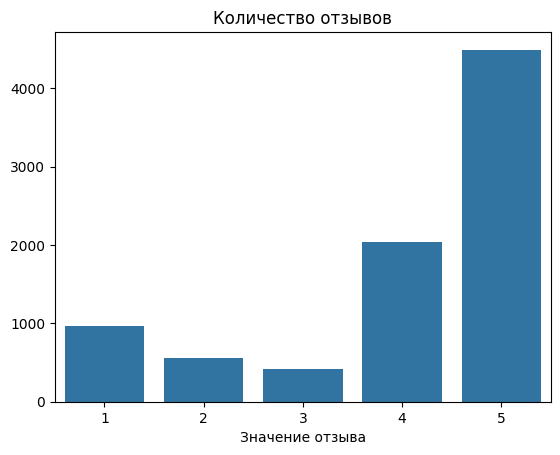

In [45]:
# plt.figure(figsize=(1, 1))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title('Количество отзывов')
plt.xlabel('Значение отзыва')
plt.xticks(rotation=0)
plt.show()


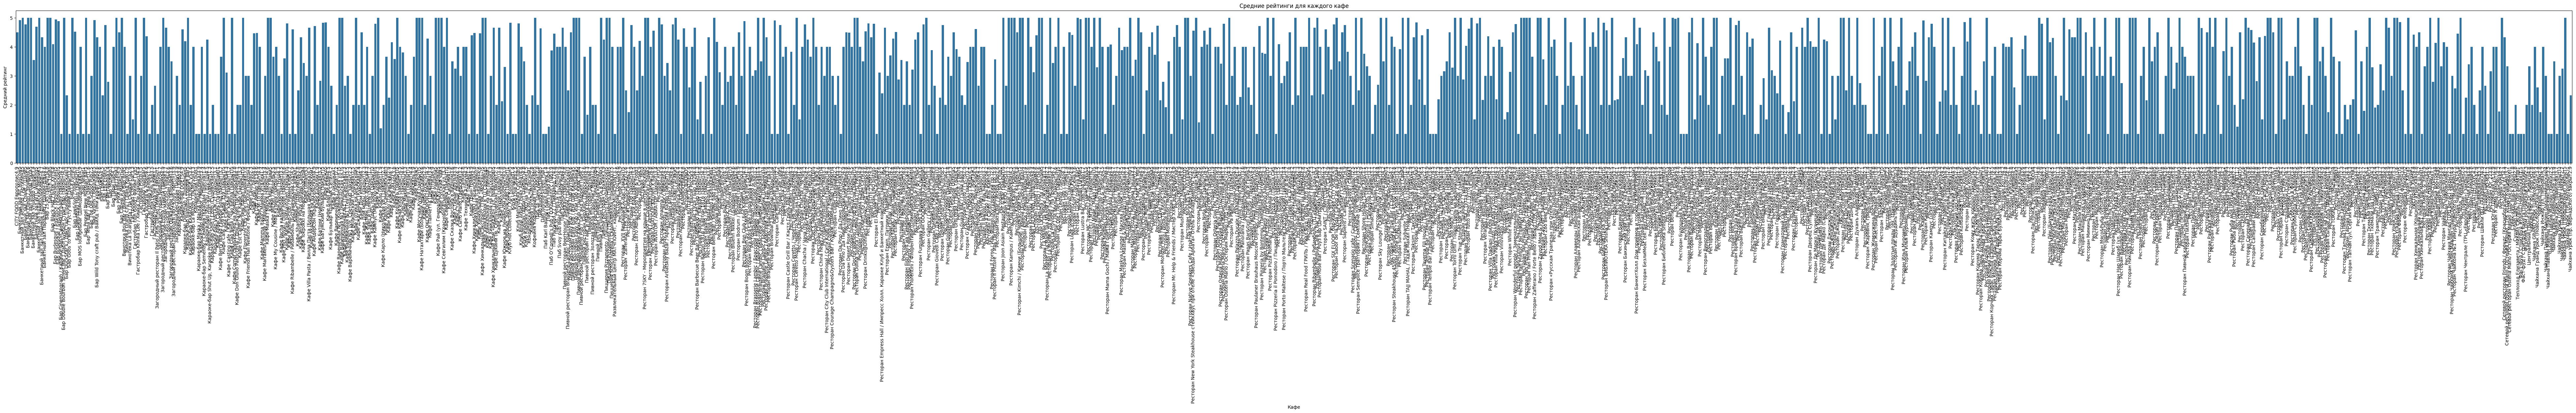

In [46]:
# Диаграмма средних рейтингов для каждого кафе
plt.figure(figsize=(100, 6))
sns.barplot(x=cafe_ratings.index, y=cafe_ratings.values)
plt.title('Средние рейтинги для каждого кафе')
plt.xlabel('Кафе')
plt.ylabel('Средний рейтинг')
plt.xticks(rotation=90)
plt.show()

# Обработка текста и балансировка классов


In [47]:
# Разделение данных на признаки и целевую переменную
X = df['review']
y = df['rating']

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

# Балансировка классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Оценка баланса классов
print(Counter(y_resampled))

Counter({5: 4490, 1: 4490, 2: 4490, 3: 4490, 4: 4490})


# Оценка моделей


In [48]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [49]:

# Определение моделей
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(),
    'k-Nearest Neighbor': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Обучение и оценка моделей
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append([name, f1])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [50]:
# Создание DataFrame с результатами
results_df = pd.DataFrame(results, columns=['Model', 'F1 Score'])
print(results_df)

# Подробный отчет для каждой модели
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


                 Model  F1 Score
0          Naive Bayes  0.648355
1  Logistic Regression  0.732274
2        Decision Tree  0.891737
3   k-Nearest Neighbor  0.631599
4        Random Forest  0.933232
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           1       0.66      0.67      0.67       899
           2       0.74      0.69      0.71       906
           3       0.67      0.76      0.71       850
           4       0.58      0.55      0.57       901
           5       0.59      0.58      0.59       934

    accuracy                           0.65      4490
   macro avg       0.65      0.65      0.65      4490
weighted avg       0.65      0.65      0.65      4490



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.77      0.75      0.76       899
           2       0.81      0.83      0.82       906
           3       0.73      0.91      0.81       850
           4       0.65      0.56      0.60       901
           5       0.70      0.64      0.67       934

    accuracy                           0.74      4490
   macro avg       0.73      0.74      0.73      4490
weighted avg       0.73      0.74      0.73      4490

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1       0.89      0.93      0.91       899
           2       0.92      0.94      0.93       906
           3       0.92      0.93      0.92       850
           4       0.85      0.81      0.83       901
           5       0.88      0.87      0.88       934

    accuracy                           0.89      4490
   macro avg       0.89      0.90      0.89

# Дополнительное задание

In [63]:
def predict_rating(comment, model, vectorizer):
    # Предобработка
    preprocessed_comment = preprocess_text(comment)
    # Векторизация
    comment_tfidf = vectorizer.transform([preprocessed_comment])
    predicted_rating = model.predict(comment_tfidf)

    return predicted_rating[0]

# Пример использования
comment = "О шикарное место, всё очень вкусно"
model = models['Random Forest']  # Выбор модели т к показал лучшие значения до этого
model.fit(X_train, y_train)  # Обучение модели
predicted_rating = predict_rating(comment, model, vectorizer)
print(f"Предполагаемая оценка: {predicted_rating}")

Предполагаемая оценка: 5
